# Data Preparation

Data is processed for models that determine the usefulness of spiral galaxies for the task of inclination measurements by leveraging the classification methodologies.

We are dealing with binary labels, where `0` denotes accepted galaxies, and `1` represent rejected images due to various anomalies, and ambiguities, or having poor quality. A few face-on galaxies (those with inclination lower than 45 degrees from face-on) has also been rejected.

**See also** [This Notebook](https://github.com/ekourkchi/incNET-data/blob/master/incNET_VGGcnn_withAugmentation/incNET_model_augmentation.ipynb) for the data augmentation of the galaxy sample with determined inclinations. In the following notebook, most of the process has been borrowed from that work.


## Augmentation

To prepare data for the full analysis, we increase the resolution of the input images to 128x128. Each images can be rotated arbitrarily, with some additional noise and other tweaks.

Note that the aspect ratio of images should not be changed to preserve the elliptical shape of the projected galaxies, and thus their inclinations.

In [4]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime
import json
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

## Augmentations

We define two variables `seq` and `seqGray` to perform augmentation on the grayscale and colorful images, respectively. The python package `imgaug` is utilized to perform the task of augmentation.

Please refer to [imaug documentation](https://imgaug.readthedocs.io/en/latest/index.html) for more details .

In [5]:
ia.seed(100)

seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

## Auxiliary Functions

In [6]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

## Sample Generating Functions

`train_test_creation` takes the `npz` file at each filter, e.g. `data_128x128_g_originals.npz`, and splits the data into training and testing batches.

10% of all galaxies with inclinations greater than 45 degrees are set aside for the testing purpose in file `<outFileRoot>test_000.npz`.

The entire training set is also stored under the name of `<outFileRoot>train_000.npz`.

In [35]:
def train_test_creation(npzFile, outFileRoot, m_iter=3):
    
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    images_c = images_
    labels_c = labels_[1,:]
    pgcIDs_c = labels_[0,:]
    
    labels_c[(labels_c < 10)] = 1  # reject
    labels_c[(labels_c > 10)] = 0  # accept

    N = images_c.shape[0]
    idx = np.arange(N)
    idx = esn_shuffle(idx, seed=0)
    images_c = images_c[idx]
    labels_c = labels_c[idx]
    pgcIDs_c = pgcIDs_c[idx]

    images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, 
                                                                                                        labels_c, 
                                                                                                        pgcIDs_c, 
                                                                                                        test_size=0.15,
                                                                                                        random_state=100
                                                                                                       )
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_test, 
                        labels=labels_test, 
                        pgcIDs=pgcIDs_test)
    
    print('created ...', npzTest)
    
    
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_train, 
                        labels=labels_train, 
                        pgcIDs=pgcIDs_train)
    
    print('created ...', npzTrain)


        
    return pgcIDs_test

The action of the following function is very similar to that of `train_test_creation`. Here, the difference is that train/test spits are taken as input parameters `pgcIDs_test` and `pgcIDs_train_list`. This is to ensure that all test/train splits are similar to each other at all various bands, `g`, `r`, `i`, and `RGB`.

In [34]:
def train_test_replication(npzFile, outFileRoot, pgcIDs_test):
       
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    images_c = images_
    labels_c = labels_[1,:]
    pgcIDs_c = labels_[0,:]
    
    labels_c[(labels_c < 10)] = 1  # reject
    labels_c[(labels_c > 10)] = 0  # accept
    
    idx = np.isin(pgcIDs_c, pgcIDs_test)
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTest)
    
    
    idx = np.logical_not(np.isin(pgcIDs_c, pgcIDs_test))
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTrain)
    
    del images_
    del labels_

    del images_c
    del labels_c
    del pgcIDs_c    

Here, we chose the `r`-band sample to create the train/test split and used the same configuration to split data at other filters, `g`, `i`, and `RGB`.

*Note:* the sample has not yet been augmented.

In [36]:
band = 'r'
pgcIDs_test = train_test_creation('./data_128x128_'+band+'_originals.npz', 
                                                     'samples_binary/'+band+'_128x128_')

for band in ['RGB', 'g', 'i']:
    train_test_replication('./data_128x128_'+band+'_originals.npz', 
                           'samples_binary/'+band+'_128x128_', 
                           pgcIDs_test)

created ... samples_binary/r_128x128_test_000.npz
created ... samples_binary/r_128x128_train_000.npz
created ... samples_binary/RGB_128x128_test_000.npz
created ... samples_binary/RGB_128x128_train_000.npz
created ... samples_binary/g_128x128_test_000.npz
created ... samples_binary/g_128x128_train_000.npz
created ... samples_binary/i_128x128_test_000.npz
created ... samples_binary/i_128x128_train_000.npz


## Examining samples

Below, we test the train and test samples.

In [7]:
data = np.load('./samples_binary/i_128x128_train_000.npz')
images = data['images'].astype(np.uint8)
labels = data['labels'] 
pgcIDs = data['pgcIDs']
del data

In [9]:
n = len(labels)

print("No. of accepted galaxies: ", len(labels[(labels==0)]))
print("No. of rejected galaxies: ", len(labels[(labels==1)]))

No. of accepted galaxies:  12637
No. of rejected galaxies:  4274


Text(0.5, 1.0, 'Train sample (i-band)')

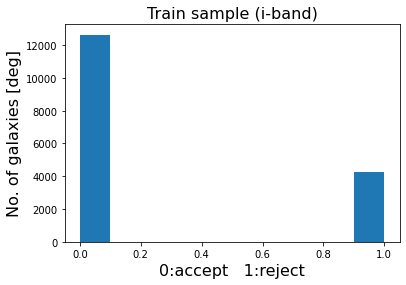

In [16]:
_ = plt.hist(labels)
plt.xlabel("0:accept   1:reject", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)
plt.title("Train sample (i-band)", fontsize=16)

### Run this part separately .....

In [43]:
%%time 

data = np.load('samples_binary/RGB_128x128_train_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_train_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_train_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_train_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 16.1 s, sys: 720 ms, total: 16.9 s
Wall time: 16.9 s


### Concatenating all grayscale images

We bundle all grayscale images together.

In order to avoid inducing other undesired biases, we demand that each training batch to have the same number of grayscale and colorful images. We invert half of the grayscale images to ensure that both black and white backgrounds are considered in the training process.

In [44]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

## Auxiliary Functions

### Augmenting an array of images

`augment_N` takes the image array and augment it several times. `N` number of images are then taken randomly and returned as output.  

In [45]:
def augment_N(images, labels, pgcIDs, filter, N, isGray=True, seed=0):
    '''
    images, labels, pgcIDs: input data
    filer: the band-pass of the input data
    N: the number of the output augmented images
    isGray: True: grayscale images, False: colorful images 
    seed: the randomness state
    '''
    
    if isGray:
        images_aug = seqGray(images=images)
    else:
        images_aug = seq(images=images)
    labels_aug = labels
    pgcIDs_aug = pgcIDs
    filter_aug = filter
    
    ii = 0 
    while len(labels_aug)<N:
        if isGray:
            images_aug = np.concatenate((images_aug, seqGray(images=images)))
        else:
            images_aug = np.concatenate((images_aug, seq(images=images)))         
        labels_aug = np.concatenate((labels_aug, labels))
        pgcIDs_aug = np.concatenate((pgcIDs_aug, pgcIDs))
        filter_aug = np.concatenate((filter_aug, filter))
        
    
    indx = esn_shuffle(np.arange(len(labels_aug)), seed=seed)
    images_aug = images_aug[indx][:N]
    labels_aug = labels_aug[indx][:N]
    pgcIDs_aug = pgcIDs_aug[indx][:N]
    filter_aug = filter_aug[indx][:N]
    
    return images_aug, labels_aug, pgcIDs_aug, filter_aug

## Generating augmented samples with uniform distribution of inclinations

Function `uniformer` takes the entire array of images, and divides it into the inclination bins of size 5 starting from 45 degrees. Each of the $5^o$ sub-samples are augmented separately using Function `augment_N`.

`N=1000` means that each of the $5^o$ intervals have 1,000 galaxies after the augmentation process. 

In [54]:
import copy 

def uniformer(images, labels, pgcIDs, filter, N=1000, isGray=True, seed=0):
    '''
    images, labels, pgcIDs: input data
    filer: the band-pass of the input data
    N: the number of the augmented images within 5 degrees of inclination interval
    isGray: True: grayscale images, False: colorful images 
    seed: the randomness state
    '''
    
    n = len(labels)
    indices = np.arange(n)
    
    for binaryLabel in [0, 1]:
        
        idx = indices[(labels==binaryLabel)]
        images_aug, labels_aug, pgcIDs_aug, filter_aug = augment_N(images[idx], 
                                                                   labels[idx], 
                                                                   pgcIDs[idx], 
                                                                   filter[idx], N, isGray=True, seed=seed)
        if binaryLabel==1:
            images_aug_ = np.concatenate((images_aug_, images_aug))
            labels_aug_ = np.concatenate((labels_aug_, labels_aug))
            pgcIDs_aug_ = np.concatenate((pgcIDs_aug_, pgcIDs_aug))
            filter_aug_ = np.concatenate((filter_aug_, filter_aug))
        else:
            images_aug_ = copy.deepcopy(images_aug)
            labels_aug_ = copy.deepcopy(labels_aug)
            pgcIDs_aug_ = copy.deepcopy(pgcIDs_aug)
            filter_aug_ = copy.deepcopy(filter_aug)

    return images_aug_, labels_aug_, pgcIDs_aug_, filter_aug_

## Batch generation

- The training batches are generated here. Each batch consists of the same number of grayscale and colorful images. 
- Half of the grayscale images are inverted to avoid overfitting

In [62]:
## Generating 50 batches of augmented training sample
for i in range(50):
    t1 =  datetime.now()

    ia.seed(2*i+12)
    
    images_aug_gri, labels_aug_gri, pgcIDs_aug_gri, filter_aug_gri = uniformer(images_gri, 
                                                                               labels_gri, 
                                                                               pgcIDs_gri, 
                                                                               filter_gri, 
                                                                               N=15000, isGray=True, seed=3*i+36)
    ia.seed(5*i+25)
    
    images_aug_RGB, labels_aug_RGB, pgcIDs_aug_RGB, filter_aug_RGB = uniformer(images_RGB, 
                                                                               labels_RGB, 
                                                                               pgcIDs_RGB, 
                                                                               filter_RGB, 
                                                                               N=5000, isGray=False, seed=3*i+41)
    N_RGB = len(labels_aug_RGB)
    N_gri = len(labels_aug_gri)

    indx = esn_shuffle(np.arange(N_gri), seed=6*i+40)
    images_aug = images_aug_gri[indx][:N_RGB]
    labels_aug = labels_aug_gri[indx][:N_RGB]
    pgcIDs_aug = pgcIDs_aug_gri[indx][:N_RGB]
    filter_aug = filter_aug_gri[indx][:N_RGB]

    n = len(images_aug)
    p = int(n/2)
    images_aug[:p] = 255 - images_aug[:p]

    ia.seed(2*i+51)
    images_aug = np.concatenate((images_aug_RGB,images_aug))
    labels_aug = np.concatenate((labels_aug_RGB,labels_aug))
    pgcIDs_aug = np.concatenate((pgcIDs_aug_RGB,pgcIDs_aug))
    filter_aug = np.concatenate((filter_aug_RGB,filter_aug))
    
    indx = np.arange(len(images_aug))
    indx = esn_shuffle(indx, seed=32*i+13)
    images_aug = images_aug[indx]
    labels_aug = labels_aug[indx]
    pgcIDs_aug = pgcIDs_aug[indx]
    filter_aug = filter_aug[indx]
    
    npzname = 'Uset0_binary_npz/128x128_train_aug_'+'%02d'%(i+1)+'.npz'
    np.savez_compressed(npzname, 
                            images=images_aug, 
                            labels=labels_aug, 
                            pgcIDs=pgcIDs_aug,
                            filter=filter_aug
                       )
    
    t2 =  datetime.now()
    print(npzname+' ... saved.')
    print("Process time: ", i+1, t2-t1)

Uset0_binary_npz/128x128_train_aug_01.npz ... saved.
Process time:  1 0:02:30.147688
Uset0_binary_npz/128x128_train_aug_02.npz ... saved.
Process time:  2 0:02:19.308046
Uset0_binary_npz/128x128_train_aug_03.npz ... saved.
Process time:  3 0:02:16.851175
Uset0_binary_npz/128x128_train_aug_04.npz ... saved.
Process time:  4 0:02:17.142847
Uset0_binary_npz/128x128_train_aug_05.npz ... saved.
Process time:  5 0:02:15.445072
Uset0_binary_npz/128x128_train_aug_06.npz ... saved.
Process time:  6 0:02:17.710284
Uset0_binary_npz/128x128_train_aug_07.npz ... saved.
Process time:  7 0:02:17.475832
Uset0_binary_npz/128x128_train_aug_08.npz ... saved.
Process time:  8 0:02:16.520965
Uset0_binary_npz/128x128_train_aug_09.npz ... saved.
Process time:  9 0:02:16.470757
Uset0_binary_npz/128x128_train_aug_10.npz ... saved.
Process time:  10 0:02:15.724158
Uset0_binary_npz/128x128_train_aug_11.npz ... saved.
Process time:  11 0:02:15.450415
Uset0_binary_npz/128x128_train_aug_12.npz ... saved.
Process ti

## Examining a training batch

In [26]:
data = np.load('Uset0_binary_npz/128x128_train_aug_01.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
pgcIDs_ = data['pgcIDs']
filter_  = data['filter']
data.close() 
del data

images_.shape, labels_.shape, pgcIDs_.shape, filter_.shape

((20000, 128, 128, 3), (20000,), (20000,), (20000,))

### The distribution of labels

As expected, each batch covers both labels uniformly. This reduces any biases that originates from the data imbalance.

Text(0.5, 1.0, 'Augmented Training (01-sample)')

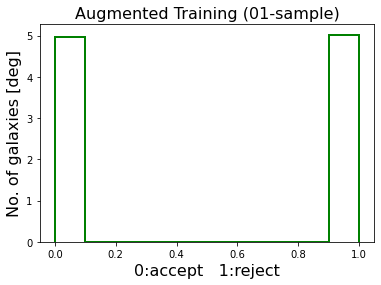

In [31]:
plt.hist(labels_, density=True, linewidth=2, histtype='step', color='g')

plt.xlabel("0:accept   1:reject", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)
plt.title("Augmented Training (01-sample)", fontsize=16)

### Visualizing images

100 images of an example batch are displayed below

- The numbers of colorful (*RGB*) and grayscale (*gri*) images are equal
- The numbers of black-on-white and white-on-black images are the same
- `g`, `r`, `i` images have the equal chance of appearance in each batch

In each panel, the PGC ID of the galaxy is in cyan. Red is the classification label and magenta is the image pass-band, i.e. `g`, `r`, `i` and `c`, where `c` stands for `RGB`.

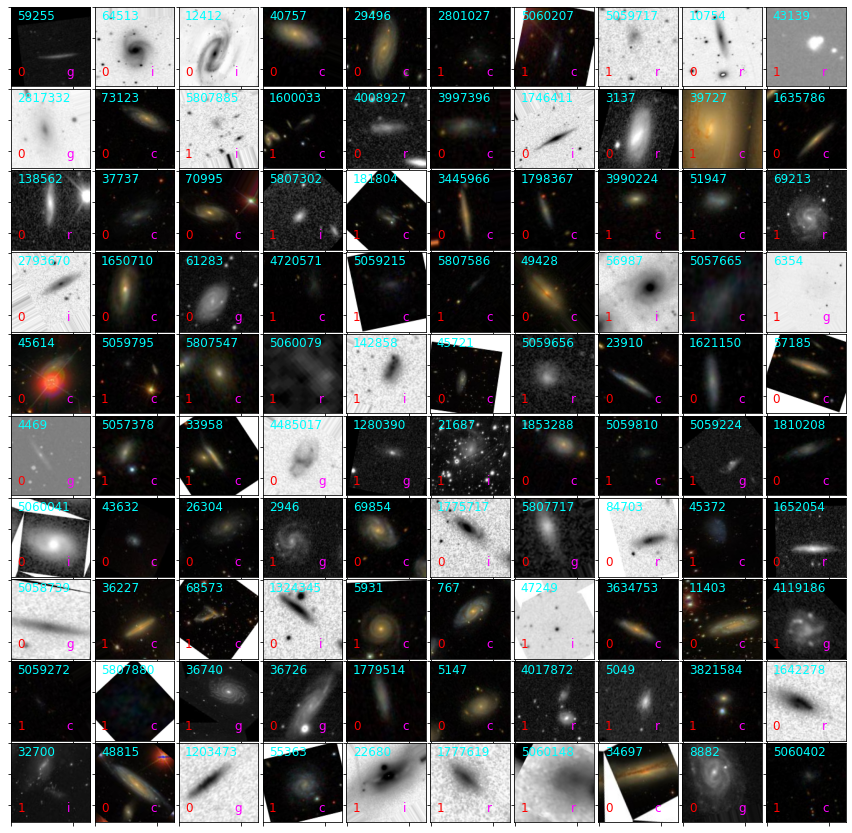

In [30]:
n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.text(10, 110, labels_[t], color='red', fontsize=12)
        ax.text(90, 110, filter_[t].decode("utf-8") , color='magenta', fontsize=12)
        ax.text(10, 20, pgcIDs_[t], color='cyan', fontsize=12)

        t+=1
  
plt.subplots_adjust(hspace=0.03, wspace=0.03)